In [15]:
import os
import math

import numpy as np
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.metrics as metrics
import sklearn.decomposition as decomposition
import sklearn.gaussian_process as gaussian_process

import ipywidgets as widgets

from pprint import pprint

from mlgrad.outl import grubbs_test

# from sklearn.model_selection import cross_val_score
# from sklearn.svm import SVR
# from sklearn.linear_model import LinearRegression

import rampy
import gcvspline

In [7]:
def load_data(fold):
    Xs = []
    Ys = []
    
    for fname in os.listdir(fold):
        if not fname.endswith(".txt"):
            continue
        xy = np.loadtxt(f"{fold}/{fname}", delimiter="\t")
        xy = xy[38:]
        xs = xy[:,0].reshape(-1)
        ys = xy[:,1].reshape(-1)
        ys -= ys.min()
        ys /= np.trapz(ys, xs)
        ys *= 1000
        Xs.append(xs)
        Ys.append(ys)
    Xs, Ys =  np.array(Xs), np.array(Ys)
    return Xs, Ys

In [8]:
dataset = {}
for f in os.scandir('.'):
    if f.name[0] == '.' or not f.name.startswith("2023"):
        continue
    if 'less30_more10' not in f.name:
        continue
    if f.is_dir():
        print(f.name)
        sd = {}
        for sf in os.scandir(f):
            if "(10)" in sf.name:
                continue
            if sf.is_dir():
                print('\t', sf.name)
                Xs, Ys = load_data(f"{f.name}/{sf.name}")
                if "191" in sf.name:
                    sd["SA_191"] = (Xs,Ys)
                if "606" in sf.name:
                    sd["SA_606"] = (Xs,Ys)
        dataset[f.name] = sd
                

20231009_13_SA_191_606_3_4_(less30_more10)_532nm
	 SA_191_3_4_less30_more10
	 SA_606_3_4_less30_more10
20231017_20_SA_191_606_6_5_(less30_more10)_532nm
	 SA_191_6_5_less30_ more10
	 SA_606_6_5_less30_ more10
20231130_28_SA_191_606_6_5_(less30_more10)_532nm
	 SA_606_6_5_(less30_more10)
	 SA_191_6_5_(less30_more10)
20231113_27_SA_191_606_6_4_(less30_more10)_532nm
	 SA_606_6_4_less 30_more10
	 SA_191_6_4_less 30_more10
20231012_16_SA_191_606_6_4_(less30_more10)_532nm
	 SA_606_6_4_more10_less30
	 SA191_6_4_more10_less30


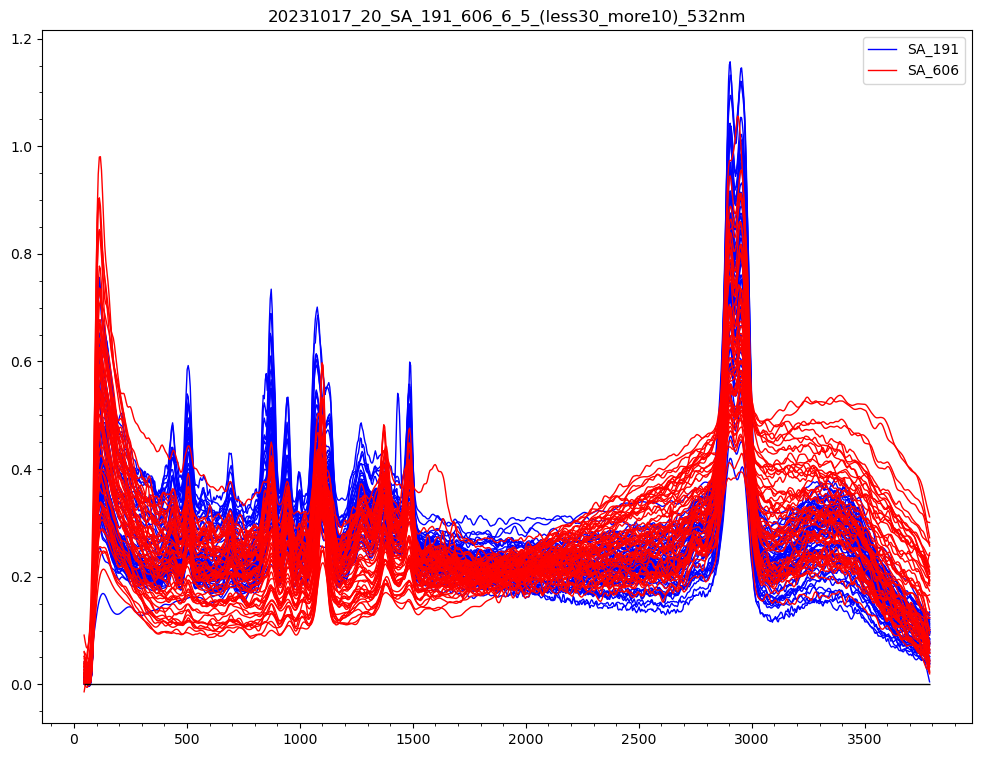

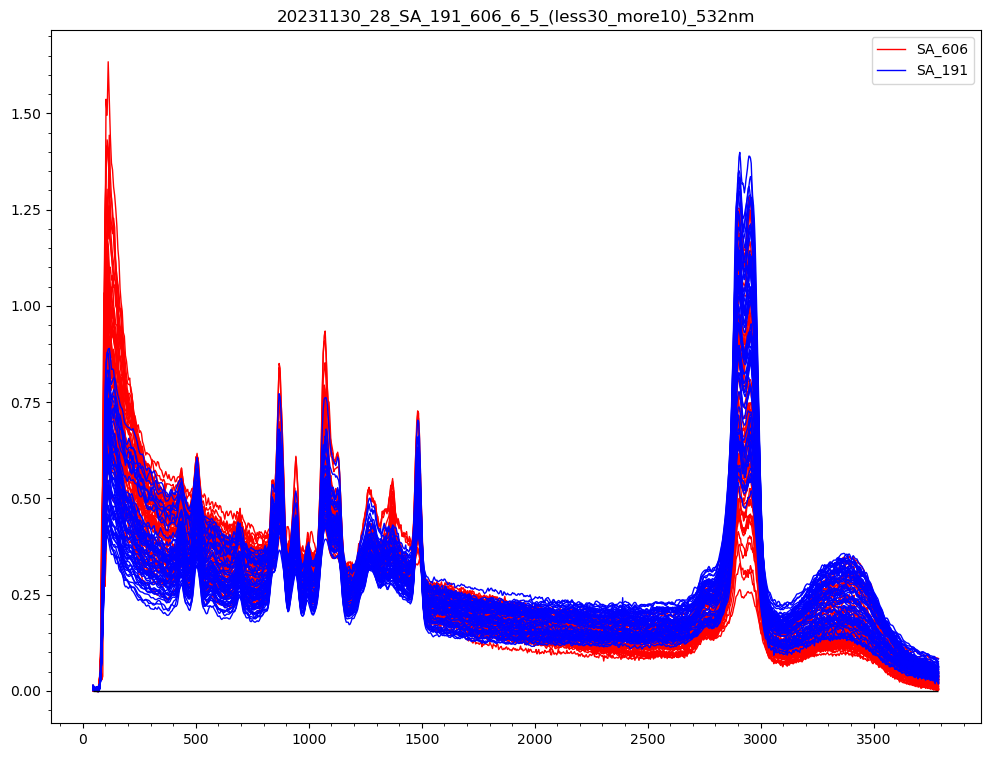

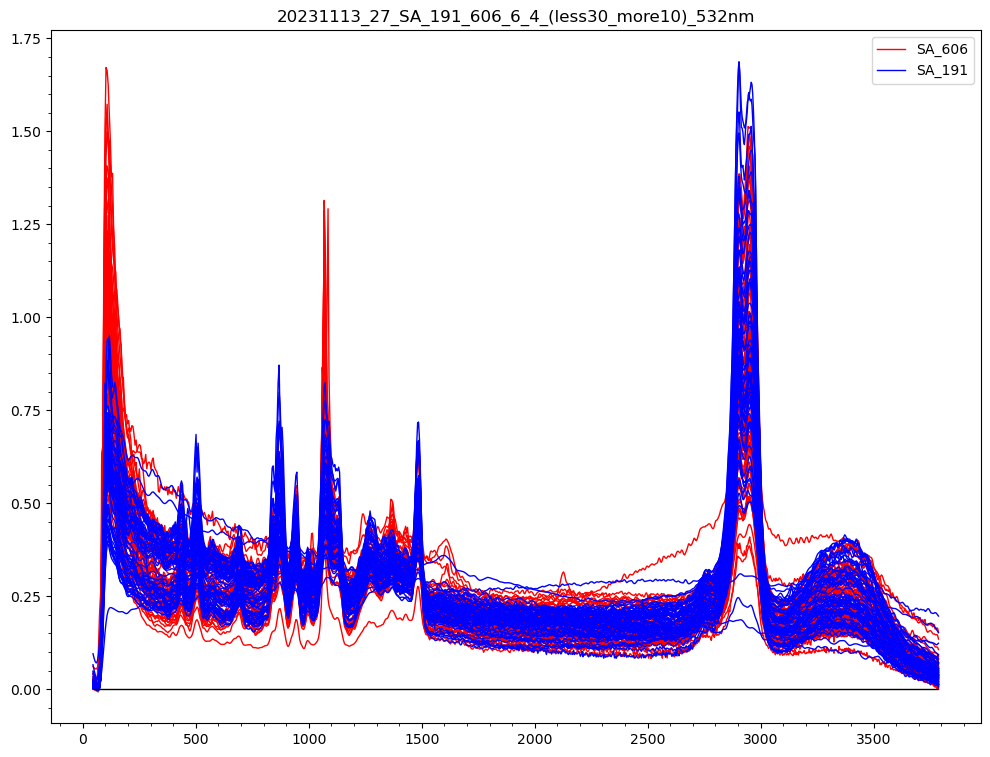

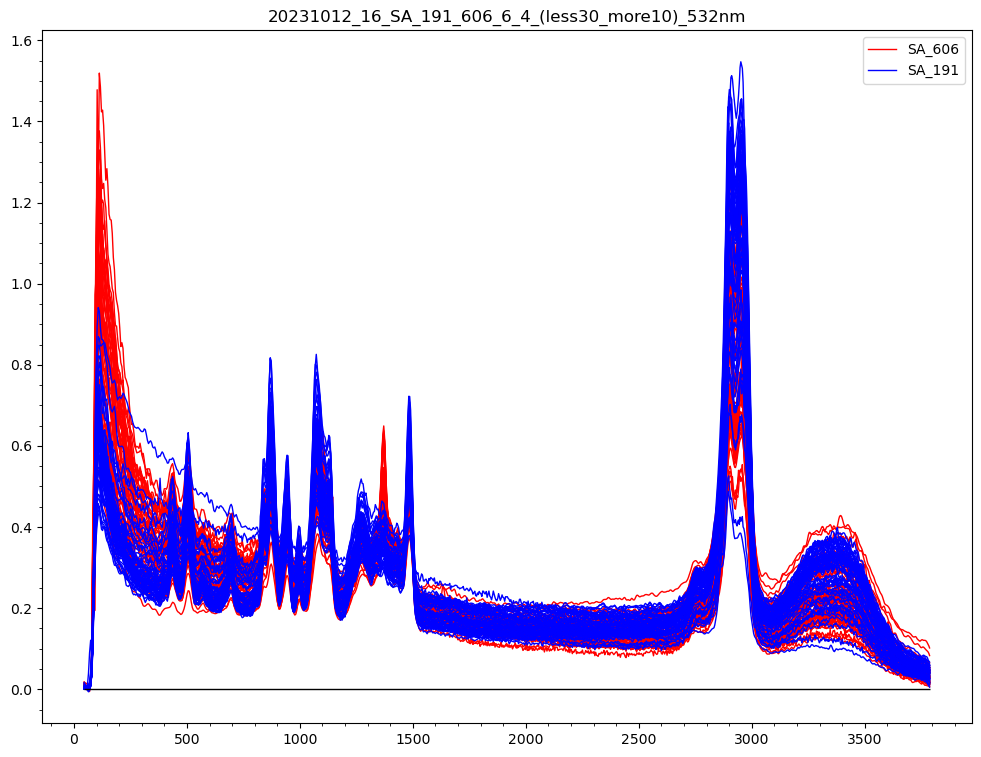

In [24]:
N = len(dataset)
i = 1
for name,ds in dataset.items():
    if 'less30_more10' not in name:
        continue
    if '6_5' not in name and '6_4' not in name:
        continue
    plt.figure(figsize=(12,9))
    plt.title(name)
    for subname,subds in ds.items():
        if subname == "SA_191":
            color='b'
        if subname == "SA_606":
            color='r'
        Xs, Ys = subds
        xs = Xs.mean(axis=0)        
        for ii,xs,ys in zip(range(len(Xs)),Xs, Ys):
            ys = rampy.despiking(xs, ys, threshold=3)
            ys = rampy.smooth(xs, ys, method="GCVSmoothedNSpline", polyoder=8)
            if ii == 0:
                plt.plot(xs, ys, linewidth=1.0, color=color, label=subname)
            else:
                plt.plot(xs, ys, linewidth=1.0, color=color)

        bs, _ = pybaselines.whittaker.arpls(ys, lam=1.0e4)
        # bs, _ = pybaselines.morphological.mor(ys)
        # bs, _ = pybaselines.morphological.mpls(ys, lam=1.0e6)
        
        ys = ys - bs
    
    i += 1
    # plt.xlim(-50,50)
    # plt.ylim(0,0.5)
    plt.minorticks_on()
    plt.legend()
    plt.hlines(0, min(Xs[0]), max(Xs[0]), linewidth=1.0, color='k')

plt.show()

In [25]:
YYs = []
XXs = []
ZZs = []
for name, ds in dataset.items():
    xt = [None,None]
    yt = [None,None]
    zt = [None,None]
    for subname, subds in ds.items():
        Xs, Ys = subds
        # Xs = Xs[0]
        # Ys = np.mean(Ys, axis=0)
        if subname == "SA_191":
            yt[0] = Ys
            xt[0] = Xs
            zt[0] = np.ones(len(Ys))
        if subname == "SA_606":
            yt[1] = Ys
            xt[1] = Xs
            zt[1] = -np.ones(len(Ys))
    XXs.extend(xt)
    YYs.extend(yt)
    ZZs.extend(zt)

XXs = tuple(XXs)
YYs = tuple(YYs)
ZZs = tuple(ZZs)


In [26]:
Xs = np.vstack(XXs)
Ys = np.vstack(YYs)
Zs = np.hstack(ZZs)

print(Xs.shape, Ys.shape, Zs.shape)

(603, 986) (603, 986) (603,)


In [ ]:
# cls = svm.LinearSVC(loss="squared_hinge", penalty="l1", 
#                     fit_intercept=False, dual=False, max_iter=1000, C=5.0)

In [ ]:
# cls.fit(Ys, Zs)

In [ ]:
# metrics.accuracy_score(Zs, cls.predict(Ys))

In [ ]:
# print(cls.coef_)

In [ ]:
# Is = [i for i,c in enumerate(cls.coef_[0]) if c != 0]
# Is = np.array(Is)
# print(len(Is))
# print(Is)
# print(cls.coef_[0][Is])

In [ ]:
# cross_val_score(cls, Ys, Zs)

In [7]:
from sklearn.decomposition import SparsePCA, PCA, NMF

In [ ]:
pca = PCA(2)
pca.fit(Ys)
Us = pca.transform(Ys)
plt.scatter(Us[:,0], Us[:,1], c=Zs)
plt.show()

In [27]:
from mlgrad.pca import find_pc_all, find_robust_pc_all
from mlgrad.pca import robust_location, location
from mlgrad.funcs import Quantile_Sqrt, Sqrt, Power
from mlgrad.af import averaging_function

wm = averaging_function("WM", Quantile_Sqrt(0.75, eps=0.01))

20231012_16_SA_191_606_6_4_(less30_more10)_532nm
SA_191 [5.0643311842633505, 0.3890485034356694]
0.12376974439099278 [-0.061]
SA_606 [1.5809469146264656, 0.30608493401310705]
-0.31388724399466733 [-0.054]


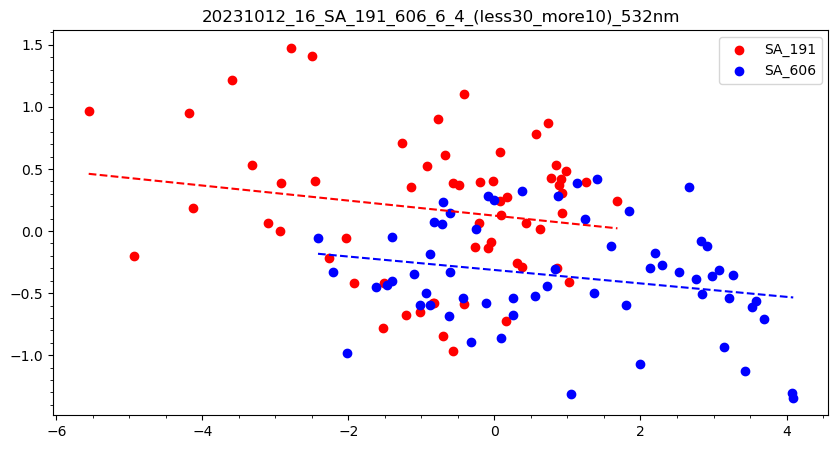

20231017_20_SA_191_606_6_5_(less30_more10)_532nm
SA_191 [1.3630953822182745, 0.3076685527264913]
-0.03965675650753314 [-0.054]
SA_606 [3.8336307580588893, 0.8933835360657019]
6.617308939562676e-17 [-0.14]


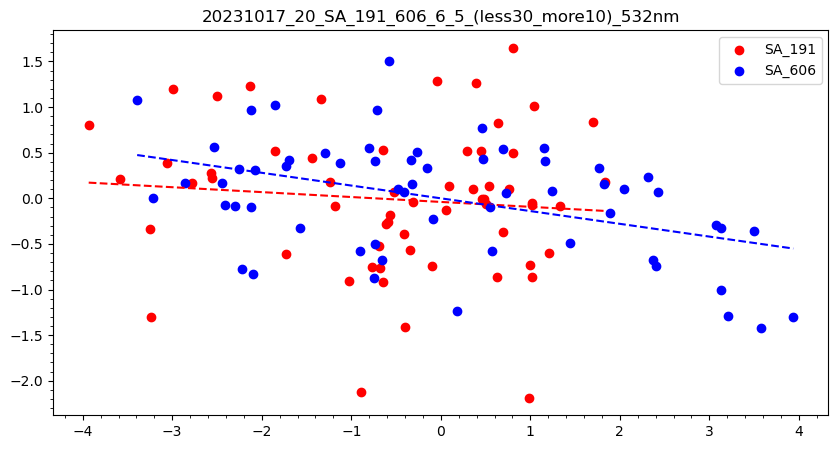

20231113_27_SA_191_606_6_4_(less30_more10)_532nm
SA_191 [2.307102379379506, 0.6561635466328588]
-0.2776232287141676 [-0.305]
SA_606 [5.438224169650136, 0.7746065024494864]
1.294087616219538e-17 [-0.075]


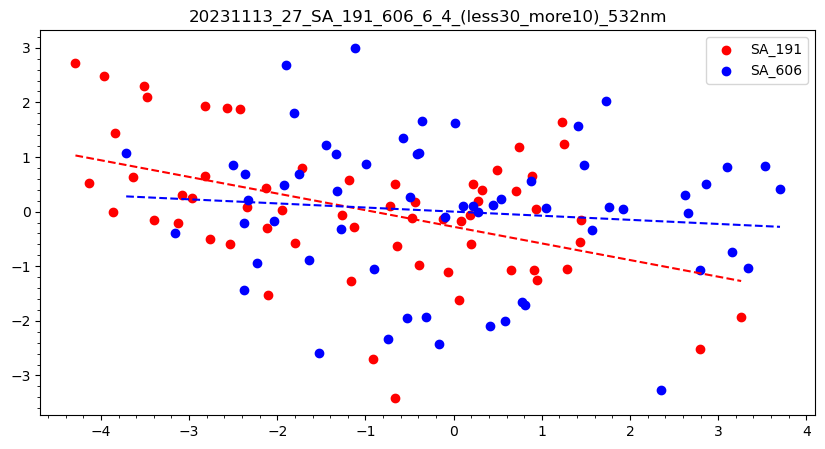

20231130_28_SA_191_606_6_5_(less30_more10)_532nm
SA_191 [1.1484494202288626, 0.4756695408155416]
0.24785115204258623 [0.062]
SA_606 [3.6871602866159163, 1.2812593553787175]
-0.42186198060273267 [-0.085]


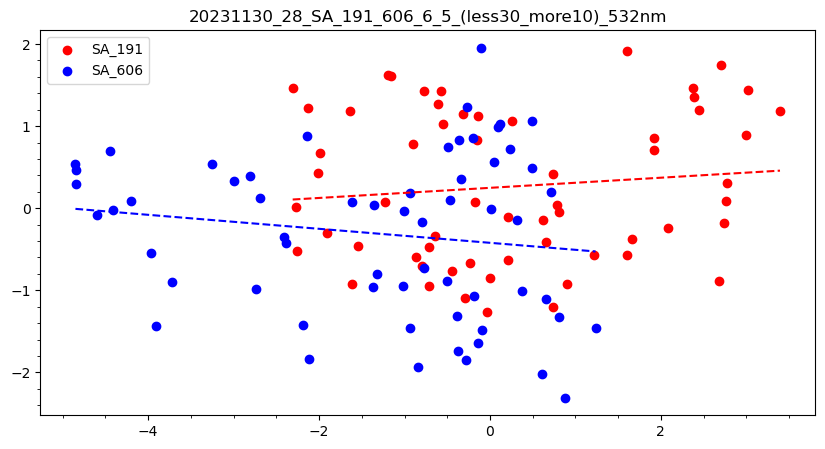

In [28]:
N = len(dataset)
for name in sorted(dataset.keys()):
    if 'less30_more10' not in name:
        continue
    if '6_5' not in name and '6_4' not in name:
        continue
    print(name)
    ds = dataset[name]
    plt.figure(figsize=(10,5))
    plt.title(name)
    for subname in sorted(ds.keys()):
        subds = ds[subname]
        if subname == "SA_191":
            color='r'
        if subname == "SA_606":
            color='b'
        Xs, Ys = subds
        c = robust_location(Ys, wm)
        Ys = Ys - c
        As, Ls, Us = find_robust_pc_all(Ys, wm, 2, verbose=False)
        Is = np.argsort(Ls)
        Ls = [Ls[i] for i in Is]
        Ls.reverse()
        As = [As[i] for i in Is]
        Us = [Us[i] for i in Is]
        print(subname, Ls)
        Us0, Us1 = Us[-1], Us[-2]
        tmp = list(zip(Us0, Us1))
        tmp.sort()
        V1, V2 = zip(*tmp)
        V1, V2 = list(V1), list(V2)
        if V2[-1] - V2[0] > 0:
            Us1 = - Us1
        plt.scatter(Us0, Us1, label=subname, c=color)
        # plt.plot(As[-1], label='1/'+subname)
        # plt.plot(As[2], label='2/'+subname)
        rgr = LinearRegression()
        rgr.fit(Us0[:,None], Us1)
        x_min, x_max = Us0.min(), Us0.max()
        plt.plot([x_min, x_max], rgr.predict([[x_min], [x_max]]), color=color, linestyle='--')
        print(rgr.intercept_, rgr.coef_)
        # plt.ylim(-2, 1)
        # plt.xlim(0, 4)    
    # plt.hlines(0, 0, len(As[0]), color='k', linestyle='--')
    plt.minorticks_on()
    plt.legend()
    plt.show()

# plt.tight_layout()
# plt.show()

In [ ]:
N = len(dataset)
# plt.figure(figsize=(10,20))
for name in sorted(dataset.keys()):
    if 'less30_more10' not in name:
        continue
    if '6_5' not in name and '6_4' not in name:
        continue
    print(name)
    ds = dataset[name]
    # plt.subplot(5,2,i)
    plt.figure(figsize=(10,5))
    plt.title(name)
    for subname in sorted(ds.keys()):
        subds = ds[subname]
    # for subname,subds in ds.items():
        if subname == "SA_191":
            color='r'
        if subname == "SA_606":
            color='b'
        Xs, Ys = subds
        # с = location(Ys)
        As, Ls, Us = find_rho_pc_all(Ys, Power(0.5), 2, verbose=False)
        Is = np.argsort(Ls)
        Ls = [Ls[i] for i in Is]
        Ls.reverse()
        As = [As[i] for i in Is]
        Us = [Us[i] for i in Is]
        print(subname, Ls)
        Us0, Us1 = Us[-1], Us[-2]
        tmp = list(zip(Us0, Us1))
        tmp.sort()
        V1, V2 = zip(*tmp)
        V1, V2 = list(V1), list(V2)
        if V2[-1] - V2[0] > 0:
            Us1 = - Us1
        plt.scatter(Us0, Us1, label=subname, c=color)
        # plt.plot(As[-1], label='1/'+subname)
        # plt.plot(As[-2], label='2/'+subname)
        rgr = LinearRegression()
        rgr.fit(Us0[:,None], Us1)
        x_min, x_max = Us0.min(), Us0.max()
        plt.plot([x_min, x_max], rgr.predict([[x_min], [x_max]]), 
                 color=color, linestyle='--')
        ##### print(rgr.intercept_, rgr.coef_)
        # plt.ylim(-0.01, 0.15)
    # plt.hlines(0, 0, len(As[0]), color='k', linestyle='--')
    plt.minorticks_on()
    plt.legend()
    plt.show()

# plt.tight_layout()
# plt.show()

In [ ]:
N = len(dataset)
i = 1
plt.figure(figsize=(10,20))
for name,ds in dataset.items():
    plt.subplot(4,2,i)
    plt.title(name)
    for subname,subds in ds.items():
        if subname == "SA_191":
            color='r'
        if subname == "SA_606":
            color='b'
        Xs, Ys = subds
        pca = PCA(2)
        pca.fit(Ys)
        Us = pca.transform(Ys)
        plt.scatter(Us[:,0], Us[:,1], label=subname, c=color)
    i += 1
    plt.minorticks_on()
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
N = len(dataset)
i = 1
plt.figure(figsize=(10,20))
for name,ds in dataset.items():
    plt.subplot(4,2,i)
    plt.title(name)
    for subname,subds in ds.items():
        if subname == "SA_191":
            color='r'
        if subname == "SA_606":
            color='b'
        Xs, Ys = subds
        nmf = SparsePCA(2, alpha=0.05)
        nmf.fit(Ys)
        Us = nmf.transform(Ys)
        plt.scatter(Us[:,0], Us[:,1], label=subname, c=color)
    i += 1
    plt.minorticks_on()
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
Ys_1 = Ys[Zs==1]
Ys_2 = Ys[Zs==-1]
As1, Ls1, Us1 = find_rho_pc_all(Ys_1, Power(0.5), 2, verbose=False)
As2, Ls2, Us2 = find_rho_pc_all(Ys_2, Power(0.5), 2, verbose=False)

def _conv_(As, Ls, Us, n):
    Is = np.argsort(Ls)
    Ls = [Ls[i] for i in Is]
    Ls.reverse()
    print(Ls)
    As = [As[i] for i in Is]
    Us = [Us[i] for i in Is]
    for i in range(2,n+1):
        Us0, Us1 = Us[-1], Us[-i]
        tmp = list(zip(Us0, Us1))
        tmp.sort()
        V1, V2 = zip(*tmp)
        V1, V2 = list(V1), list(V2)
        if V2[-1] - V2[0] > 0:
            Us1 = - Us1
        Us[-i] = Us1
    return As, Ls, Us

As1, Ls1, Us1 = _conv_(As1, Ls1, Us1, 2)
As2, Ls2, Us2 = _conv_(As2, Ls2, Us2, 2)

In [ ]:
plt.scatter(Us1[-1], Us1[-2], c='r')
plt.scatter(Us2[-1], Us2[-2], c='b')
plt.show()

In [ ]:
m = 15
pca = SparsePCA(m, alpha=0.1)
pca.fit(Ys)
print(Ys.shape)

In [ ]:
plt.figure(figsize=(15,10))
for k in range(len(pca.components_)):
    plt.plot(pca.components_[k], label=str(k))
plt.minorticks_on()
plt.legend()
plt.show()

In [ ]:
Us = pca.transform(Ys)

In [ ]:
Ys_p = pca.inverse_transform(Us)

In [ ]:
plt.figure(figsize=(15,6))
for k in range(15):
    plt.plot(Xs[k], Ys_p[k], color='b')
for k in range(16,32):
    plt.plot(Xs[k], Ys_p[k], color='r')
plt.minorticks_on()
plt.show()

In [ ]:
for i,U in enumerate(Us[:5]):
    plt.plot(U, label=str(i), marker='o', markersize=4)
plt.legend()
plt.show()

In [ ]:
cls2 = svm.LinearSVC(loss="squared_hinge", penalty="l1", 
                    fit_intercept=False, dual=False, max_iter=500, C=1.0)
cls2.fit(Us, Zs)

In [ ]:
metrics.accuracy_score(Zs, cls2.predict(Us))

In [ ]:
Is = [i for i,c in enumerate(cls2.coef_[0]) if c != 0]
Is = np.array(Is)
print(len(Is))
print(Is)

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

In [ ]:
cvals = cross_val_score(cls2, Us, Zs, cv=StratifiedShuffleSplit(22, test_size=0.2))

In [ ]:
plt.plot(sorted(cvals), marker='o')
plt.hlines(np.mean(cvals), 0, 20)

In [ ]:
def func() -> tuple[int, int]:
    return 1,2,3